# Greengenes OTU Clustering Benchmark

This notebook tests the effects of clustering at differnt OTU thresholds on taxonomic information and classification accuracy, using the Greengenes 16S rRNA gene reference database.

In [18]:
import os
import qiime2 as q2
from qiime2.plugins import rescript, feature_table as ft
import pandas as pd
from glob import glob
import timeit
from rescript.cross_validate import _check_time
import tempfile
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('max_colwidth', 0)

%matplotlib inline

# Define inputs

Modify the filepaths here to your local filepaths to run this notebook.
The filepaths below merely point to the sequence and taxonomy files for the greengenes 13_8 release, clustered at different OTU % similarities.

Greengenes files can be downloaded and unzipped from here:

ftp://greengenes.microbio.me/greengenes_release/gg_13_5/gg_13_8_otus.tar.gz

**DO NOT MODIFY ANY OTHER CELLS IN THIS NOTEBOOK IF YOU ARE ATTEMPTING TO REPLICATE THESE RESULTS**

In [2]:
# N jobs to use
n_jobs = 4

# location of reference database files
dbdir = '../../../ref_dbs/gg_13_8_otus/'
dbs = {
    'gg_{0}'.format(n): {
        'seqs': q2.Artifact.import_data(
            'FeatureData[Sequence]', dbdir + 'rep_set/{0}_otus.fasta'.format(n)),
        'taxa': q2.Artifact.import_data(
            'FeatureData[Taxonomy]', dbdir + 'taxonomy/{0}_otu_taxonomy.txt'.format(n),
            view_type='HeaderlessTSVTaxonomyFormat')}
    for n in ['64', '79', '88', '91', '94', '97', '99']}


# Perform CV Classification
Both k-fold and "perfect classifiers" (no CV, leaky data, best possible performance)

In [3]:
# Cross-validation
times_cv = {}
for n, v in dbs.items():
    s, t = v['seqs'], v['taxa']
    print(n)
    exp_taxa_fp = '../data/expected/{0}_expected_taxonomy.qza'.format(n)
    if not os.path.exists(exp_taxa_fp):
        start = timeit.default_timer()
        exp, obs, = rescript.actions.evaluate_cross_validate(s, t, n_jobs=n_jobs)
        times_cv[n] = timeit.default_timer() - start
        exp.save(exp_taxa_fp)
        obs.save('../data/observed/{0}_observed_taxonomy.qza'.format(n))

gg_64
gg_79
gg_88
gg_91
gg_94
gg_97
gg_99
Validation: 14.00s


/Users/nbokulich/miniconda3/envs/qiime2-2020.5-dev/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fold 0 split: 26.52s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 0 fit: 913.69s
Fold 0 classify: 1975.79s
Fold 1 split: 22.64s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 1 fit: 861.96s
Fold 1 classify: 1925.18s
Fold 2 split: 21.87s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Fold 2 fit: 830.71s
Fold 2 classify: 1867.59s
Total Runtime: 8461.67s


In [8]:
# "Perfect" classifier, no cross-validation
times_nocv = {}
for n, v in dbs.items():
    s, t = v['seqs'], v['taxa']
    print(n)
    obs_taxa_fp = '../data/observed/{0}_observed_taxonomy_noCV.qza'.format(n)
    exp_taxa_fp = '../data/expected/{0}_expected_taxonomy_noCV.qza'.format(n)
    if not os.path.exists(exp_taxa_fp):
        start = timeit.default_timer()
        _, _, obs, = rescript.actions.evaluate_fit_classifier(s, t, n_jobs=n_jobs)
        times_nocv[n] = timeit.default_timer() - start
        obs.save(obs_taxa_fp)
        t.save(exp_taxa_fp)


gg_64
gg_79
gg_88
gg_91
gg_94
gg_97
Validation: 6.98s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 564.78s
Classification: 2491.23s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 3.09s
Total Runtime: 3066.08s
gg_99
Validation: 13.18s


/Users/nbokulich/Desktop/projects/q2-feature-classifier/q2_feature_classifier/classifier.py:102: UserWarning: The TaxonomicClassifier artifact that results from this method was trained using scikit-learn version 0.22.1. It cannot be used with other versions of scikit-learn. (While the classifier may complete successfully, the results will be unreliable.)
  warnings.warn(warning, UserWarning)


Training: 1446.73s
Classification: 5906.85s


/Users/nbokulich/Desktop/projects/RESCRIPt/rescript/evaluate.py:67: UserWarning: The lists of input taxonomies and labels are different lengths. Additional taxonomies will be labeled numerically by their order in the inputs. Note that if these numbers equal any existing labels, those data will be grouped in the visualization.
  warnings.warn(msg, UserWarning)


Evaluation: 7.11s
Total Runtime: 7373.87s


In [6]:
exp_taxonomies = {os.path.splitext(os.path.basename(fp))[0].replace('_expected_taxonomy', ''): 
                  q2.Artifact.load(fp) for fp in glob('../data/expected/*')}
obs_taxonomies = {os.path.splitext(os.path.basename(fp))[0].replace('_observed_taxonomy', ''): 
                  q2.Artifact.load(fp) for fp in glob('../data/observed/*')}


# Evaluate Classification Accuracy

In [11]:
class_eval, = rescript.actions.evaluate_classifications(
    expected_taxonomies = [exp_taxonomies[i] for i in sorted(exp_taxonomies.keys())],
    observed_taxonomies = [obs_taxonomies[i] for i in sorted(obs_taxonomies.keys())],
    labels = sorted(obs_taxonomies.keys()))
class_eval.save('../data/eval/gg_otu_cluster_classification_eval.qzv')

'../data/eval/gg_otu_cluster_eval.qzv'

# Evaluate Taxonomic Information

In [18]:
tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = [dbs[i]['taxa'] for i in sorted(dbs.keys())],
    labels = sorted(dbs.keys()))
tax_eval.save('../data/eval/gg_otu_cluster_taxonomic_eval.qzv')
tax_eval, = rescript.actions.evaluate_taxonomy(
    taxonomies = [dbs[i]['taxa'] for i in sorted(dbs.keys())],
    labels = sorted(dbs.keys()),
    rank_handle_regex="^[dkpcofgs]__")
tax_eval.save('../data/eval/gg_otu_cluster_taxonomic_eval_dropemptyranks.qzv')

'../data/eval/gg_otu_cluster_taxonomic_eval_dropemptyranks.qzv'

# Make a pretty figure

The interactive figs are great, but we need to generate a static figure for publication :(

In [17]:
fig_data = dict()
with tempfile.TemporaryDirectory() as temp_dir_name:
    for f in glob('../data/eval/*.qzv'):
        name = f.split('/')[-1].split('.qzv')[0]
        f = q2.Visualization.load(f)
        f.export_data(temp_dir_name)
        fig_data[name] = q2.Metadata.load(temp_dir_name + '/data.tsv').to_dataframe()


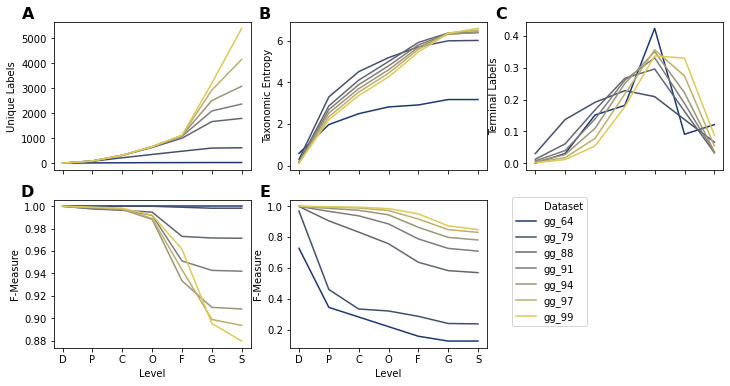

In [70]:
plot_keys = ['gg_otu_cluster_taxonomic_eval',
             'gg_otu_cluster_taxonomic_eval',
             'gg_otu_cluster_taxonomic_eval_dropemptyranks',
             'gg_otu_cluster_classification_eval',
             'gg_otu_cluster_classification_eval']
signals = ['Unique Labels',
           'Taxonomic Entropy',
           'Proportion of Features Terminating at Depth',
           'F-Measure',
           'F-Measure']
labels = list('ABCDEF')

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axes = axes.flatten()
axes[-1].remove()
for ax, key, signal, label in zip(axes, plot_keys, signals, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    dat = fig_data[key].copy()
    dat['Level'] = dat['Level'].replace({
        1: 'D', 2: 'P', 3: 'C', 4: 'O',
        5: 'F', 6: 'G', 7: 'S'})
    if ax == axes[3]:
        dat = dat[dat['Dataset'].isin(['gg_64_noCV', 'gg_79_noCV', 'gg_88_noCV',
                                       'gg_91_noCV', 'gg_94_noCV', 'gg_97_noCV',
                                       'gg_99_noCV'])]
    if ax == axes[4]:
        dat = dat[dat['Dataset'].isin(['gg_64', 'gg_79', 'gg_88', 'gg_91',
                                       'gg_94', 'gg_97', 'gg_99'])]
        legend = 'brief'
    else:
        legend = False
    g = sns.lineplot(x='Level', y=signal, hue='Dataset', data=dat, ax=ax,
                     legend=legend, palette='cividis', sort=False)
    if ax == axes[2]:
        ax.set_ylabel('Terminal Labels')
    if ax == axes[4]:
        ax.legend(bbox_to_anchor=(1.1, 1.05))
        
fig.savefig('../data/plots/greengenes_evaluation.pdf', bbox_inches='tight')


Fig XXX. Taxonomic information (A-C) and classification accuracy (D-E) of Greengenes 16S rRNA gene database clustered at different similarity thresholds. Subpanels show taxonomic/classification characteristics at each taxonomic level: A, Number of unique taxonomic labels; B, Taxonomic entropy; C, number of taxa that terminate at that level; D, optimal classification accuracy (as F-Measure) without cross-validation (simulating best possible classification accuracy when the true label is known but classification accuracy may be confounded by other similar hits in the database); E, classification accuracy (F-Measure) with cross-validation (simulating realistic classification tasks when the correct label is unknown). Level labels on x-axis: D = domain, P = phylum, C = class, O = order, F = family, G = genus, S = species.